In [46]:
from google.colab import drive
import os
import numpy as np
# import matplotlib.pyplot as plt
from IPython.display import display
# import time
import PIL
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import TensorDataset, DataLoader
# import torch.optim as optim

from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision import models, transforms

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [3]:
# check if training using GPU is possible
torch.cuda.is_available()

False

In [4]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = "/content/gdrive/My Drive/Kaggle/NaturalPainters" # for original email
project_folder = "/content/gdrive/My Drive/NaturalPainters" 
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [70]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


# **Painting**

In [7]:
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    batch_size = 128 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.01 #@param {type:"number"}
    #betas = (0.5, 0.9) #@param
    epochs = 1000 #@param {type:"slider", min:1, max:1000, step:1}
    #print_interval = 25 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

In [8]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
      super(Generator, self).__init__()

      self.out_features = img_height * img_width

      self.lin = nn.Linear(in_features, self.out_features)

      self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                      kernel_size = (4, 4), stride = (1, 1), bias = False)
      self.norm1 = nn.BatchNorm2d(num_features)

      self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm2 = nn.BatchNorm2d(num_features)

      self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm3 = nn.BatchNorm2d(num_features)

      self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm4 = nn.BatchNorm2d(num_features)

      self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                      kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
      self.norm5 = nn.BatchNorm2d(num_features)

      self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
      x = self.lin(x)
      x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
      x = self.norm1(x)
      x = F.relu(self.conv2(x), inplace = True)
      x = self.norm2(x)
      x = F.relu(self.conv3(x), inplace = True)
      x = self.norm3(x)
      x = F.relu(self.conv4(x), inplace = True)
      x = self.norm4(x)
      x = F.relu(self.conv5(x), inplace = True)
      x = self.norm5(x)

      return torch.tanh(self.conv6(x))

In [73]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor()
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):
        print("Download VGG19 (batch normalized) as pre-trained.")
        if device == 'cuda':
            extractor = models.vgg19_bn(True).features.cuda().eval()
        else:
            extractor = models.vgg19_bn(True).features.eval()
        requires_grad(extractor, False)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    def gram_matrix(self, input):

        (a, b, c, d) = input.size()
        features = input.view(a, b, c * d)
        G = features @ features.transpose(1, 2)
        return G.div(b * c * d)

    def forward(self, gen_stroke, true_stroke):

        self.feature_extractor(gen_stroke)
        gen_stroke_features = [out for out in self.outputs.stored]
        
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        self.loss = []
        
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight
                             for gen_layer, true_layer, weight 
                        in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        

        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * 5000
                             for gen_layer, true_layer, weight 
                      in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
    
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        
        self.outputs.remove()

In [74]:
generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

feature_extractor = FeatureExtractor(hparams.layers_weights, device)

generator_path = "GAN_generator_1e.pth"

generator.load_state_dict(torch.load("./results/" + generator_path, 
                                     map_location = torch.device(device)))

for param in generator.parameters():
    generator.requires_grad = False

generator.to(device).eval()

Training is performed using CPU.

Download VGG19 (batch normalized) as pre-trained.


Generator(
  (lin): Linear(in_features=12, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [58]:
# dive into folder with images to paint
%cd /content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters/images
images_folder = '/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters/images/*'

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters/images


In [55]:
# add the desired images to the folder from paper github
# !wget -c https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/alaska_landscape.jpg
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/vanc.jpg

--2022-02-09 14:08:39--  https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/alaska_landscape.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104856 (102K) [image/jpeg]
Saving to: ‘alaska_landscape.jpg’

alaska_landscape.jp 100%[===================>] 102.40K  --.-KB/s    in 0.02s   

2022-02-09 14:08:39 (5.86 MB/s) - ‘alaska_landscape.jpg’ saved [104856/104856]



In [18]:
def load_img(img_path, 
             thumb_size = None, 
             crop = 256, 
             out_size = None):

        img = PIL.Image.open(img_path)
    
        if thumb_size is not None:
            img.thumbnail((thumb_size, thumb_size), PIL.Image.ANTIALIAS)
        if out_size is not None:
            img = transforms.CenterCrop(crop)(img).resize((out_size, out_size))

        return img

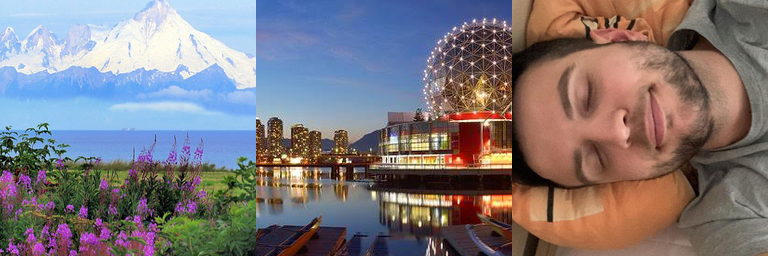

In [60]:
image_list = []
image_path_list = []
for img_path in glob.glob(images_folder):
    img = load_img(img_path, thumb_size = 512, crop = 256, out_size = 256)
    image_list.append(img)
    image_path_list.append(img_path)

display(PIL.Image.fromarray(np.hstack((np.array(image_list[0]),
                                       np.array(image_list[1]), 
                                       np.array(image_list[2])))))

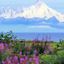


Image tensor has size torch.Size([3, 64, 64])


In [68]:
img0 = load_img(image_path_list[0], thumb_size = 512, crop = 256, out_size = 64)
display(img0)
img0_tensor = to_tensor(img0).to(device)
print(f"\nImage tensor has size {img0_tensor.shape}")

In [78]:
from torch.utils.data import TensorDataset, DataLoader

def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

current_npz = 'episodes_2.npz'

strokes, actions = load_data(current_npz)

strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
actions = torch.stack([torch.from_numpy(action).float() for action in actions])

dataset = TensorDataset(strokes, actions)

dataloader = DataLoader(dataset, 
                        batch_size = 32, 
                        shuffle = False)

for i, (stroke, action) in enumerate(dataloader):
    print(action.shape)
    gen_strokes = generator(action)
    break

torch.Size([32, 12])


In [79]:
gen_strokes.shape

torch.Size([32, 3, 64, 64])

In [83]:
size = gen_strokes[0].shape[-1] # take one stroke from batch (hparams.num_strokes = 32) and take img_size (img_width = img_height)
size # 64 in our case

64

In [84]:
darkness = 1

In [175]:
# returns a tensor filled with the scalar value `1` (white), with the same size as gen_strokes[0]
# so canvas is a white area of a size (3, 64, 64)
canvas = torch.ones_like(gen_strokes[0], requires_grad = True, dtype = torch.float32)
canvas.shape

torch.Size([3, 64, 64])

current stroke


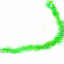

current canvas


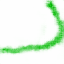

current stroke


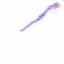

current canvas


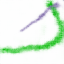

current stroke


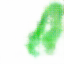

current canvas


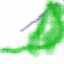

current stroke


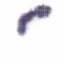

current canvas


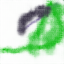

current stroke


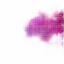

current canvas


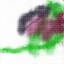

current stroke


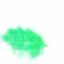

current canvas


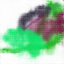

current stroke


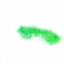

current canvas


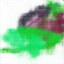

current stroke


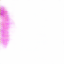

current canvas


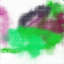

current stroke


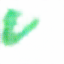

current canvas


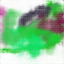

current stroke


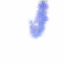

current canvas


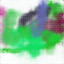

current stroke


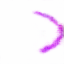

current canvas


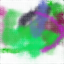

current stroke


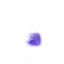

current canvas


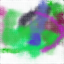

current stroke


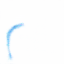

current canvas


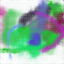

current stroke


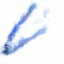

current canvas


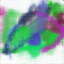

current stroke


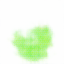

current canvas


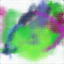

current stroke


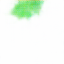

current canvas


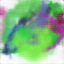

current stroke


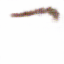

current canvas


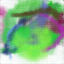

current stroke


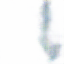

current canvas


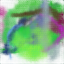

current stroke


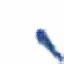

current canvas


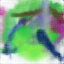

current stroke


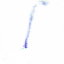

current canvas


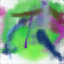

current stroke


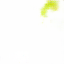

current canvas


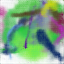

current stroke


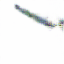

current canvas


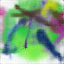

current stroke


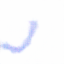

current canvas


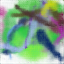

current stroke


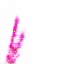

current canvas


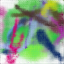

current stroke


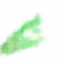

current canvas


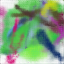

current stroke


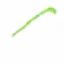

current canvas


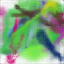

current stroke


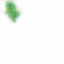

current canvas


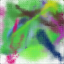

current stroke


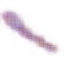

current canvas


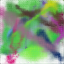

current stroke


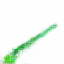

current canvas


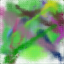

current stroke


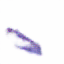

current canvas


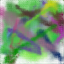

current stroke


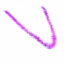

current canvas


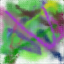

current stroke


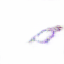

current canvas


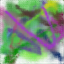

In [176]:
# iterating over num_strokes to paint
for i, stroke in enumerate(gen_strokes):
    print('current stroke')
    display(to_pil_image(stroke))

    # what we want to do is to calculate the “opacity” of an individual brush stroke pixel 
    # by computing how dark it is relative to the darkest pixel (full opacity) in the brush stroke

    # in the following lines we compute brush_color - the darkest value inside the channel
    # we iterate over 3 channels and image rows and compute for each row minimum (darkest) value in column - output is (3, 64)
    # then we iterate inside row and get the darkest color for each channel - output is 3 values
    # the values obtained can be out of interval [0, 1] (between black and white), therefore we force (clamp) them to this interval
    # we make reshape 3 -> (1, 3, 1, 1) - batch of one image with 3 channels of size (1, 1)
    # we expand the darkest value of channel for the full image size in this channel - output is (1, 3, 64, 64) 
    brush_color = stroke.min(1)[0].min(1)[0].clamp_(0, 1).view(-1, 3, 1, 1)
    brush_color = brush_color.expand(-1, 3, size, size)

    # get the "darkness" of each individual pixel in a stroke by averaging
    # in other words, each pixel is represented by 3 channels
    # we define darkness of a pixel as an average amongst its values in 3 channels - output is (64, 64)
    darkness_mask = torch.mean(stroke, 0)

    # make the value of a darker stroke higher
    # first we reshape mask from (64, 64) to (1, 1, 64, 64) to have the same niumber of dimensions as brush_stroke
    # originally the darker values are lower, by subtracting from 1, the darker values are higher
    # so, now, the closer to 1 - darker
    darkness_mask = 1 - torch.reshape(darkness_mask, (-1, 1, size, size))

    # scale this darkness mask from 0 to 1 by dividing each value in mask on the maximum possible in the mask
    darkness_mask = darkness_mask / torch.max(darkness_mask)

    # replace the original stroke with one that has all colored pixels set to the actual color used in two steps

    # step 1: boolean mask corresponding to the size of image (3, 64, 64) which if the value was 1 (white) contains True, otherwise False 
    stroke_whitespace = torch.eq(stroke, 1.)

    # step 2: if at the given coordinate in stroke there was white we will keep white,
    # if there was some another value - we take the darkest in this channel
    maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)

    if gpu:
        maxed_stroke = maxed_stroke.cuda()
        darkness_mask = darkness_mask.cuda()

    # linearly blend
    # that means that if the pixel of current stroke is dark, it has a large value and we keep mostly it + a little bit of canvas
    # if stroke pixel is light, then we take a little bit of it and mostly canvas value
    canvas = (darkness_mask) * maxed_stroke + (1 - darkness_mask) * canvas
    print('current canvas')
    display(to_pil_image(canvas.squeeze()))


In [178]:
canvas.shape

torch.Size([1, 3, 64, 64])

In [180]:
canvas.view(1, *canvas.shape).shape

torch.Size([1, 1, 3, 64, 64])

In [161]:
canvas.squeeze().shape

torch.Size([3, 64, 64])

In [160]:
canvas.shape

torch.Size([1, 3, 64, 64])

In [158]:
c.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [141]:
((darkness_mask * maxed_stroke) + ((1 - darkness_mask) * canvas)).shape

torch.Size([1, 3, 64, 64])

In [140]:
((1 - darkness_mask) * canvas).shape

torch.Size([1, 3, 64, 64])

In [134]:
1 * darkness_mask

tensor([[[[0.0081, 0.0009, 0.0016,  ..., 0.0046, 0.0107, 0.0628],
          [0.0024, 0.0002, 0.0004,  ..., 0.0011, 0.0016, 0.0068],
          [0.0029, 0.0006, 0.0024,  ..., 0.0004, 0.0007, 0.0029],
          ...,
          [0.0032, 0.0006, 0.0011,  ..., 0.0033, 0.0020, 0.0035],
          [0.0025, 0.0004, 0.0008,  ..., 0.0015, 0.0009, 0.0022],
          [0.0220, 0.0028, 0.0037,  ..., 0.0071, 0.0042, 0.0119]]]],
       grad_fn=<MulBackward0>)

In [123]:
torch.mean(stroke, 0)

tensor([[0.9938, 0.9993, 0.9987,  ..., 0.9965, 0.9918, 0.9520],
        [0.9982, 0.9999, 0.9997,  ..., 0.9992, 0.9988, 0.9948],
        [0.9978, 0.9996, 0.9982,  ..., 0.9997, 0.9995, 0.9978],
        ...,
        [0.9976, 0.9995, 0.9991,  ..., 0.9975, 0.9985, 0.9973],
        [0.9981, 0.9997, 0.9994,  ..., 0.9988, 0.9993, 0.9983],
        [0.9832, 0.9978, 0.9972,  ..., 0.9946, 0.9968, 0.9909]],
       grad_fn=<MeanBackward1>)

In [115]:
brush_stroke.clamp_(0, 1)

tensor([0.0000, 0.7279, 0.0000], grad_fn=<ClampBackward1>)

In [109]:
a = torch.tensor([0.3,0.5,0])

In [110]:
a.clamp_(0, 1)

tensor([0.3000, 0.5000, 0.0000])

In [111]:
stroke

tensor([[[0.9974, 0.9997, 0.9988,  ..., 0.9980, 0.9926, 0.9621],
         [0.9980, 0.9999, 0.9997,  ..., 0.9992, 0.9984, 0.9931],
         [0.9979, 0.9995, 0.9987,  ..., 0.9998, 0.9995, 0.9982],
         ...,
         [0.9964, 0.9996, 0.9989,  ..., 0.9978, 0.9983, 0.9968],
         [0.9985, 0.9997, 0.9993,  ..., 0.9994, 0.9994, 0.9990],
         [0.9722, 0.9969, 0.9965,  ..., 0.9931, 0.9954, 0.9869]],

        [[0.9955, 0.9993, 0.9987,  ..., 0.9983, 0.9953, 0.9597],
         [0.9982, 0.9999, 0.9996,  ..., 0.9998, 0.9992, 0.9964],
         [0.9971, 0.9994, 0.9969,  ..., 0.9999, 0.9998, 0.9985],
         ...,
         [0.9977, 0.9996, 0.9988,  ..., 0.9977, 0.9980, 0.9979],
         [0.9986, 0.9999, 0.9996,  ..., 0.9994, 0.9995, 0.9989],
         [0.9869, 0.9982, 0.9969,  ..., 0.9945, 0.9971, 0.9940]],

        [[0.9886, 0.9990, 0.9987,  ..., 0.9932, 0.9876, 0.9342],
         [0.9983, 0.9999, 0.9998,  ..., 0.9986, 0.9986, 0.9948],
         [0.9984, 0.9997, 0.9990,  ..., 0.9995, 0.9991, 0.